In [17]:
import pytorch_lightning as pl
import json
from monai.utils import set_determinism
import os
from monai.data import DataLoader, Dataset
import torch
from monai.inferers import sliding_window_inference
from functools import partial
import numpy as np
import time
import matplotlib.pyplot as plt
from monai.transforms import Compose, EnsureType, AsDiscrete, Activations, LoadImaged, NormalizeIntensityd, ToTensord, AddChanneld
from bone_data.bone_data import ConvertToMultiChannelForBoneClassesd
#os.environ["CUDA_VISIBLE_DEVICES"] = "7"

set_determinism(seed=0)
with open('bone_data/data_bone_08_15_split.json') as f:
     data = json.load(f)
test_files = data['test'][50:52]
train_files = data['train'][0:10]
print(test_files)
print(len(test_files))
def get_test_dataloader():
    test_transform = Compose(
    [
    LoadImaged(keys=["image", "label"]),
    ConvertToMultiChannelForBoneClassesd(keys = ['label']),
    AddChanneld(keys = ["image"]),
    NormalizeIntensityd(keys = "image",
                       nonzero = True,
                       channel_wise = True),
    ToTensord(keys=["image", "label"]),
    ])
    test_ds = Dataset(data=test_files, transform=test_transform)
    test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, pin_memory = True, num_workers = 4)

    return test_loader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

[{'image': ['bone_data/images_nifti_split/bone_B44R_6.nii.gz'], 'label': 'bone_data/masks_nifti_split/mask_B44R_6.nii.gz'}, {'image': ['bone_data/images_nifti_split/bone_B44R_7.nii.gz'], 'label': 'bone_data/masks_nifti_split/mask_B44R_7.nii.gz'}]
2
cuda


In [ ]:
def predict_test_inference(chosen_model = "DBAHNET", threshold  = 0.6):
    if chosen_model == "UNET":
        from trainer_bone_unet import BONEUNET
        CKPT = "ckpt/EXP_BONE_UNET_FINAL/last.ckpt"
        model = BONEUNET().load_from_checkpoint(CKPT).to(device).eval()
    if chosen_model == "ATTENTIONUNET":
        CKPT = "ckpt/EXP_BONE_ATTENTIONUNET_2/Epoch 85-MeanDiceScore0.9611.ckpt"
        from trainer_bone_attentionunet import BONEATTENTIONUNET
        model = BONEATTENTIONUNET().load_from_checkpoint(CKPT).to(device).eval()
    if chosen_model == "UNETR":
        CKPT = "ckpt/EXP_BONE_UNETR_2/Epoch 60-MeanDiceScore0.9667.ckpt"
        from trainer_bone_unetr import BONEUNETR
        model = BONEUNETR().load_from_checkpoint(CKPT).to(device).eval()
    if chosen_model == "SWINUNETR":
        from trainer_bone_swinunetr import BONESWINUNETR
        CKPT = "ckpt/EXP_BONE_SWINUNETR_2/Epoch 60-MeanDiceScore0.9739.ckpt"
        model = BONESWINUNETR().load_from_checkpoint(CKPT).to(device).eval()
    if chosen_model =="DBAHNET":
        from trainer_bone_dbahnet import  DBAHNET
        CKPT = "ckpt/EXP_BONE_DBAHNET_3_48_444_v3/Epoch 58-MeanDiceScore0.9855.ckpt"
        model = DBAHNET().load_from_checkpoint(CKPT).to(device).eval() 
    test_dataloader = get_test_dataloader()   
    roi_size = (320,320,32)
    sw_batch_size = 1
    inferer = partial(sliding_window_inference, roi_size = roi_size, sw_batch_size = sw_batch_size, predictor = model, overlap = 0.6)
    post_trans = Compose(
            [EnsureType(), Activations(sigmoid=True), AsDiscrete(threshold = threshold)]
        )

    if not os.path.exists("inference_plots"):
         os.mkdir("inference_plots")
    with torch.no_grad():
         for batch_idx, batch_data in enumerate(test_dataloader):
            print("Element 1")
            image, label = batch_data['image'].cuda(), batch_data['label'].cuda()[0].detach().cpu().numpy()
            start_time = time.time()
            seg = post_trans(inferer(image))[0].detach().cpu().numpy()
            inference_time = time.time() - start_time
            print("Inference time : (s)",inference_time)
            seg_out = np.zeros((seg.shape[1], seg.shape[2], seg.shape[3]))
            seg_out[seg[0] == 1] = 0
            seg_out[seg[1] == 1] = 1
            seg_out[seg[2] == 1] = 2
            lab_out = np.zeros((seg.shape[1], seg.shape[2], seg.shape[3]))
            lab_out[label[0] == 1] = 0
            lab_out[label[1] == 1] = 1
            lab_out[label[2] == 1] = 2        
            image = image[0][0].detach().cpu().numpy()
            slice_num = 5
            plt.figure("image", (18, 6))
            plt.subplot(1, 3, 1)
            plt.title("image")
            plt.imshow(image[:, :, slice_num], cmap="gray")
            plt.subplot(1, 3, 2)
            plt.title("label")
            plt.imshow(lab_out[:, :, slice_num], cmap = "gray")
            plt.subplot(1, 3, 3)
            plt.title("segmentation")
            plt.imshow(seg_out[:, :, slice_num], cmap ="gray")
            plt.show()
            break


#                                    Control scans
# DBAHNET

Element 1
Inference time : (s) 479.8199853897095


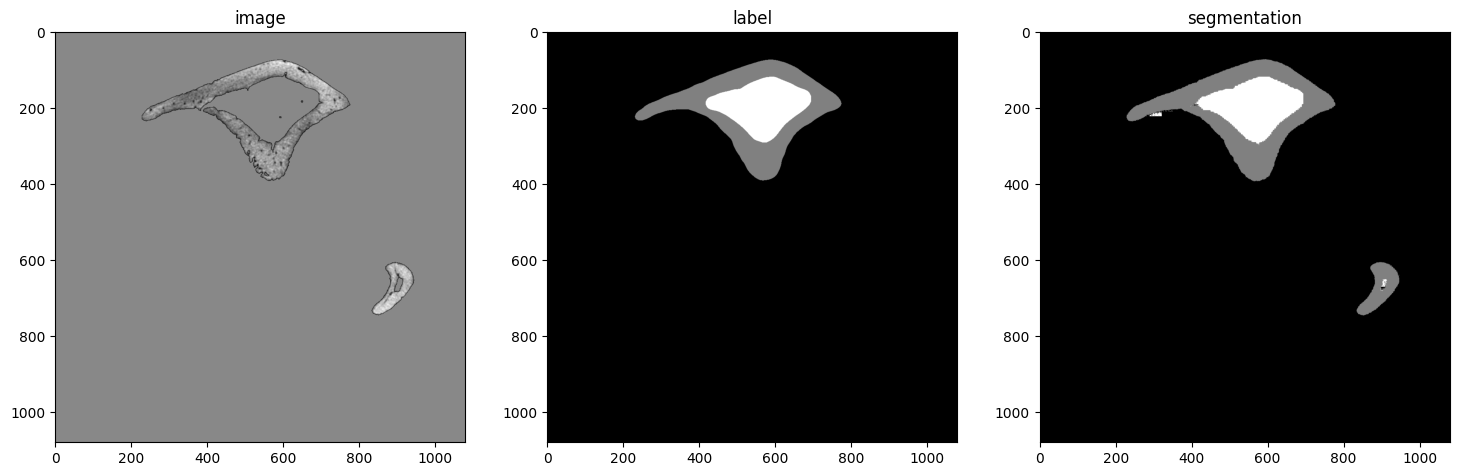

In [18]:
chosen_model = "DBAHNET" # [UNET, ATTENTIONUNET, UNETR, SWINUNETR, DBAHNET]
predict_test_inference(chosen_model = chosen_model)

# ATTENTIONUNET

Element 1
Inference time : (s) 76.68567109107971


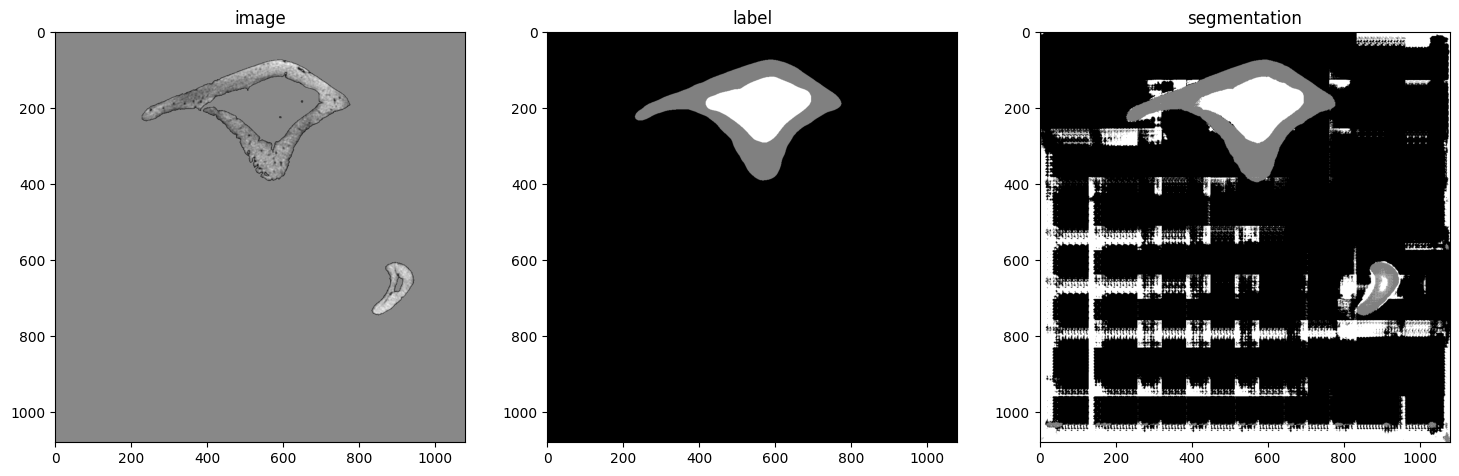

In [19]:
chosen_model = "ATTENTIONUNET" # [UNET, ATTENTIONUNET, UNETR, SWINUNETR, DBAHNET]
predict_test_inference(chosen_model = chosen_model)

# UNETR

Element 1
Inference time : (s) 96.49913549423218


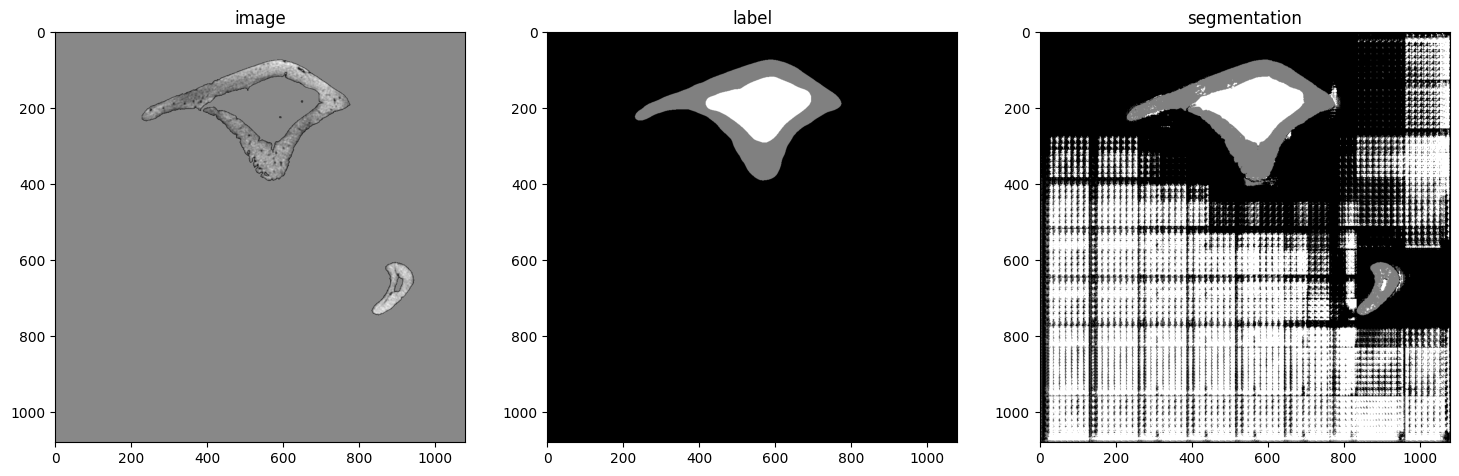

In [21]:
chosen_model = "UNETR" # [UNET, ATTENTIONUNET, UNETR, SWINUNETR, DBAHNET]
predict_test_inference(chosen_model = chosen_model)

# SWINUNETR

Element 1
Inference time : (s) 81.73188900947571


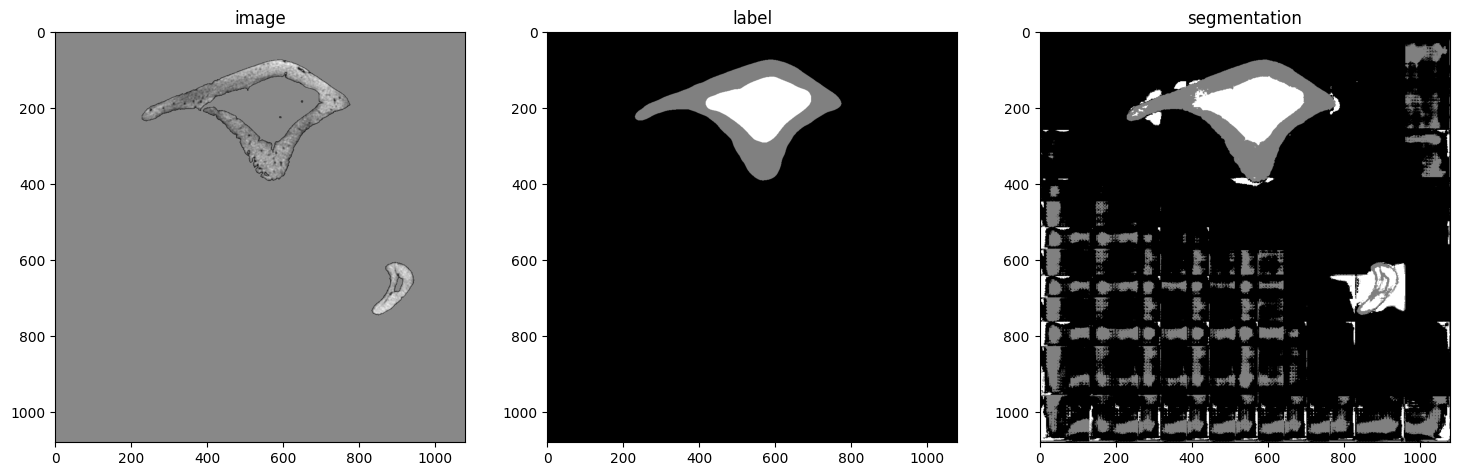

In [20]:
chosen_model = "SWINUNETR" # [UNET, ATTENTIONUNET, UNETR, SWINUNETR, DBAHNET]
predict_test_inference(chosen_model = chosen_model)

# UNET

In [ ]:
chosen_model = "UNET" # [UNET, ATTENTIONUNET, UNETR, SWINUNETR, DBAHNET]
predict_test_inference(chosen_model = chosen_model)

# Inference by region
## Region 100%


In [56]:
import pytorch_lightning as pl
import json
from monai.utils import set_determinism
import os
from monai.data import DataLoader, Dataset
import torch
from monai.inferers import sliding_window_inference
from functools import partial
import numpy as np
import time
import matplotlib.pyplot as plt
from monai.transforms import Compose, EnsureType, AsDiscrete, Activations, LoadImaged, NormalizeIntensityd, ToTensord, AddChanneld
from bone_data.bone_data import ConvertToMultiChannelForBoneClassesd
#os.environ["CUDA_VISIBLE_DEVICES"] = "7"

set_determinism(seed=0)
with open('bone_data/data_test_100_split.json') as f:
     data = json.load(f)
test_files = data['test'][1:3]
test_files_last = []
for f in test_files:
    if "_9.nii.gz" in str(f):
        test_files_last.append(f)
        
test_files = test_files_last
print(test_files)
def get_test_dataloader(test_files = test_files):
    test_transform = Compose(
    [
    LoadImaged(keys=["image", "label"]),
    ConvertToMultiChannelForBoneClassesd(keys = ['label']),
    AddChanneld(keys = ["image"]),
    NormalizeIntensityd(keys = "image",
                       nonzero = True,
                       channel_wise = True),
    ToTensord(keys=["image", "label"]),
    ])
    test_ds = Dataset(data=test_files, transform=test_transform)
    test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, pin_memory = True, num_workers = 4)

    return test_loader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

[{'image': ['bone_data/images_nifti_test_100/bone_B42L_9.nii.gz'], 'label': 'bone_data/masks_nifti_test_100/mask_B42L_9.nii.gz'}]
cuda
[{'image': ['bone_data/images_nifti_test_100/bone_B42L_9.nii.gz'], 'label': 'bone_data/masks_nifti_test_100/mask_B42L_9.nii.gz'}]
cuda


In [57]:
def predict_test_inference(chosen_model = "DBAHNET", threshold  = 0.6, slice_num = 5):
    if chosen_model == "UNET":
        from trainer_bone_unet import BONEUNET
        CKPT = "ckpt/EXP_BONE_UNET_FINAL/last.ckpt"
        model = BONEUNET().load_from_checkpoint(CKPT).to(device).eval()
    if chosen_model == "ATTENTIONUNET":
        CKPT = "ckpt/EXP_BONE_ATTENTIONUNET_2/Epoch 85-MeanDiceScore0.9611.ckpt"
        from trainer_bone_attentionunet import BONEATTENTIONUNET
        model = BONEATTENTIONUNET().load_from_checkpoint(CKPT).to(device).eval()
    if chosen_model == "UNETR":
        CKPT = "ckpt/EXP_BONE_UNETR_2/Epoch 60-MeanDiceScore0.9667.ckpt"
        from trainer_bone_unetr import BONEUNETR
        model = BONEUNETR().load_from_checkpoint(CKPT).to(device).eval()
    if chosen_model == "SWINUNETR":
        from trainer_bone_swinunetr import BONESWINUNETR
        CKPT = "ckpt/EXP_BONE_SWINUNETR_2/Epoch 60-MeanDiceScore0.9739.ckpt"
        model = BONESWINUNETR().load_from_checkpoint(CKPT).to(device).eval()
    if chosen_model =="DBAHNET":
        from trainer_bone_dbahnet import  DBAHNET
        CKPT = "ckpt/EXP_BONE_DBAHNET_3_48_444_v3/Epoch 58-MeanDiceScore0.9855.ckpt"
        model = DBAHNET().load_from_checkpoint(CKPT).to(device).eval() 
    test_dataloader = get_test_dataloader()   
    roi_size = (320,320,32)
    sw_batch_size = 1
    inferer = partial(sliding_window_inference, roi_size = roi_size, sw_batch_size = sw_batch_size, predictor = model, overlap = 0.6)
    post_trans = Compose(
            [EnsureType(), Activations(sigmoid=True), AsDiscrete(threshold = threshold)]
        )

    if not os.path.exists("inference_plots"):
         os.mkdir("inference_plots")
    with torch.no_grad():
         for batch_idx, batch_data in enumerate(test_dataloader):
            print("Element 1")
            image, label = batch_data['image'].cuda(), batch_data['label'].cuda()[0].detach().cpu().numpy()
            image = image[:,:,:,:,70:70+32]; label = label[:,:,:,70:70+32]
            print(image.shape)
            print(label.shape)
            start_time = time.time()
            seg = post_trans(inferer(image))[0].detach().cpu().numpy()
            inference_time = time.time() - start_time
            print("Inference time : (s)",inference_time)
            seg_out = np.zeros((seg.shape[1], seg.shape[2], seg.shape[3]))
            seg_out[seg[0] == 1] = 0
            seg_out[seg[1] == 1] = 1
            seg_out[seg[2] == 1] = 2
            lab_out = np.zeros((seg.shape[1], seg.shape[2], seg.shape[3]))
            lab_out[label[0] == 1] = 0
            lab_out[label[1] == 1] = 1
            lab_out[label[2] == 1] = 2        
            image = image[0][0].detach().cpu().numpy()
            plt.figure("image", (18, 6))
            ax = plt.subplot(1, 3, 1)
            plt.axis("off")
            plt.title("image")
            plt.imshow(image[100:550,420:1020, slice_num], cmap="gray")
            plt.subplot(1, 3, 2)
            plt.axis("off")
            plt.title("label")
            plt.imshow(lab_out[100:550,420:1020, slice_num], cmap = "gray")
            plt.subplot(1, 3, 3)
            plt.title("segmentation")
            plt.imshow(seg_out[100:550,420:1020, slice_num], cmap ="gray")
            plt.tight_layout()

            # Define the starting point (20, 20)
            start_x = 20
            start_y = 20

            # Define the length of the line in pixels (20 pixels down)
            line_length = 100

            # Calculate the ending point of the line
            end_x = start_x
            end_y = start_y + line_length
            arrow_params = dict(arrowstyle='<->', color='blue', linewidth=2)
            plt.annotate('', xy=(start_x, start_y), xytext=(end_x, end_y), arrowprops=arrow_params)

            # Plot the line
            plt.axis("off")
            plt.tight_layout()

            plt.show()
        
            break
            


Element 1
Element 1
torch.Size([1, 1, 1080, 1080, 32])
(3, 1080, 1080, 32)
torch.Size([1, 1, 1080, 1080, 32])
(3, 1080, 1080, 32)
Inference time : (s) 10.04537296295166
Inference time : (s) 10.04537296295166


The figure layout has changed to tight
The figure layout has changed to tight


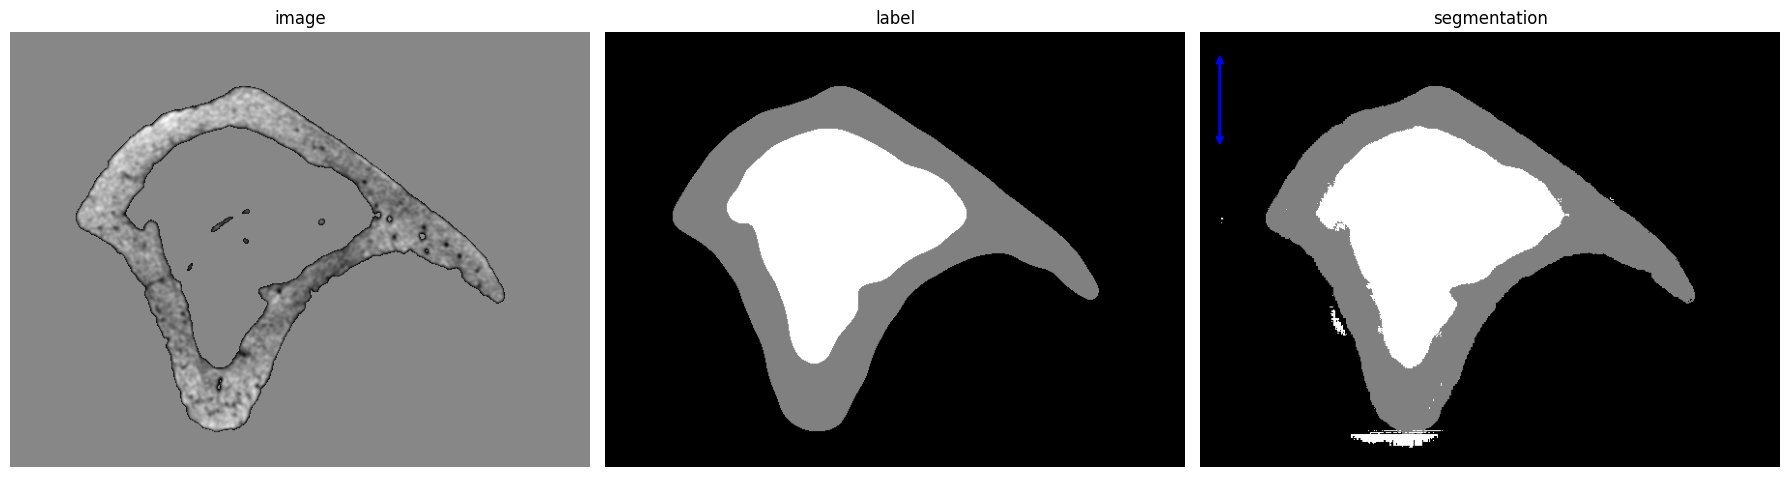

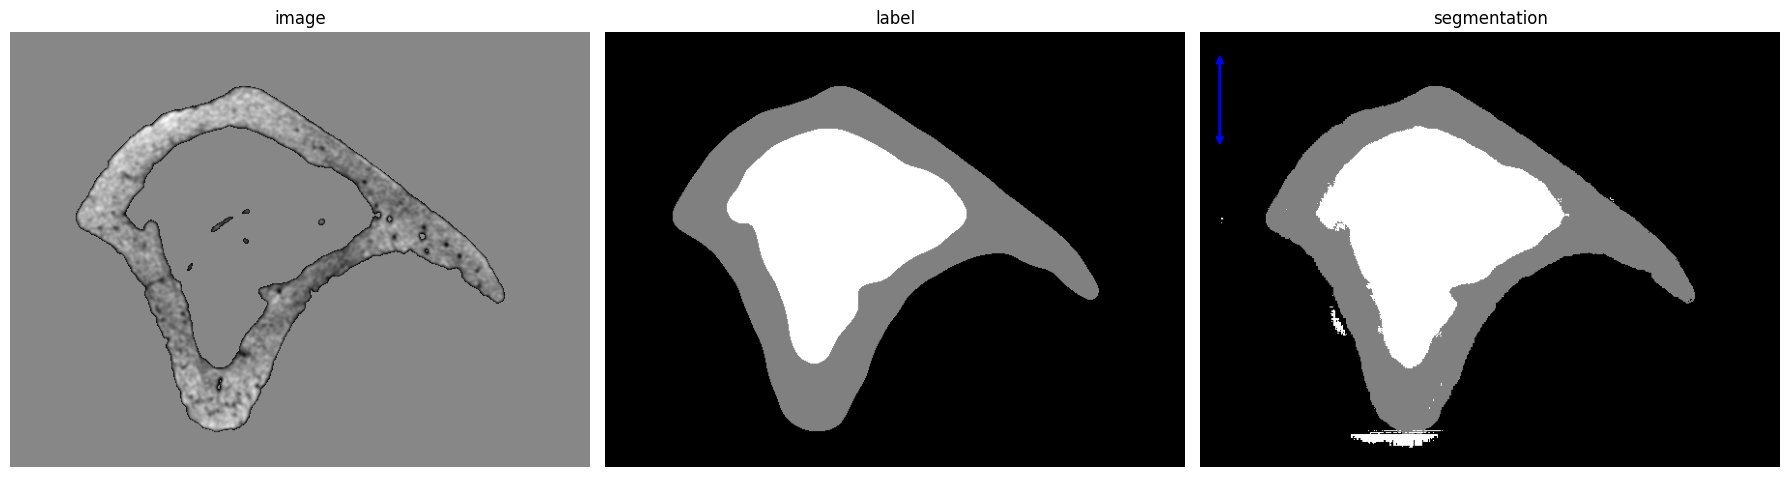

In [58]:
chosen_model = "SWINUNETR" # [UNET, ATTENTIONUNET, UNETR, SWINUNETR, DBAHNET]
predict_test_inference(chosen_model = chosen_model, slice_num = 5)

Element 1
Element 1
torch.Size([1, 1, 1080, 1080, 32])
(3, 1080, 1080, 32)
torch.Size([1, 1, 1080, 1080, 32])
(3, 1080, 1080, 32)
Inference time : (s) 30.893293380737305
Inference time : (s) 30.893293380737305


The figure layout has changed to tight
The figure layout has changed to tight


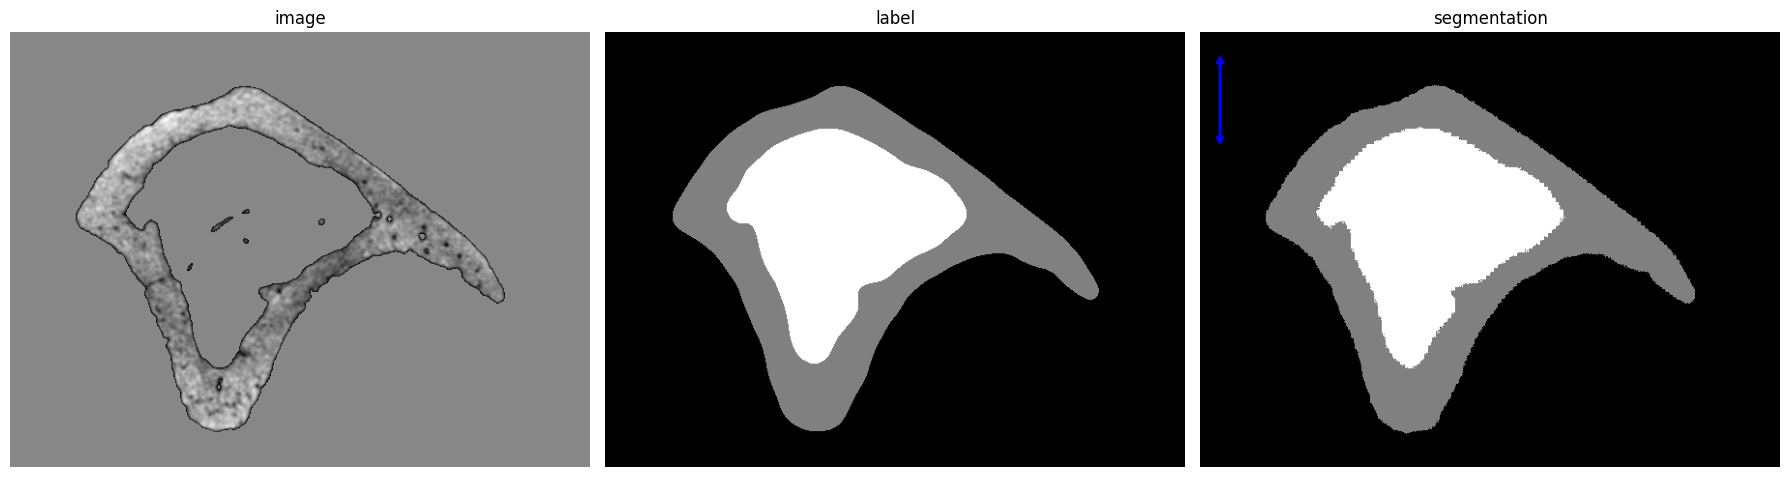

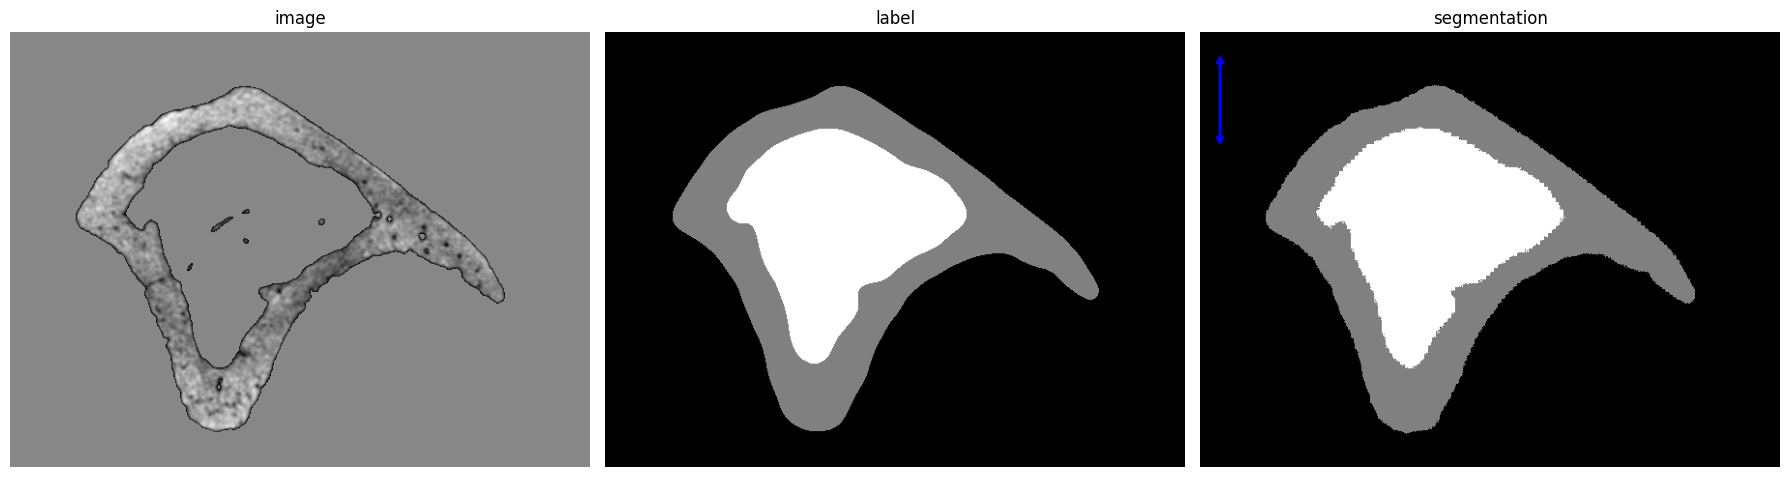

In [59]:
chosen_model = "DBAHNET" # [UNET, ATTENTIONUNET, UNETR, SWINUNETR, DBAHNET]
predict_test_inference(chosen_model = chosen_model, slice_num = 5)

# Inference by region 75%

In [31]:
import pytorch_lightning as pl
import json
from monai.utils import set_determinism
import os
from monai.data import DataLoader, Dataset
import torch
from monai.inferers import sliding_window_inference
from functools import partial
import numpy as np
import time
import matplotlib.pyplot as plt
from monai.transforms import Compose, EnsureType, AsDiscrete, Activations, LoadImaged, NormalizeIntensityd, ToTensord, AddChanneld
from bone_data.bone_data import ConvertToMultiChannelForBoneClassesd
#os.environ["CUDA_VISIBLE_DEVICES"] = "7"

set_determinism(seed=0)
with open('bone_data/data_test_75_split.json') as f:
     data = json.load(f)
test_files = data['test']
test_files_last = []
for f in test_files:
    if "B42L_6.nii.gz" in str(f):
        test_files_last.append(f)
        
test_files = test_files_last
print(test_files)
def get_test_dataloader(test_files = test_files):
    test_transform = Compose(
    [
    LoadImaged(keys=["image", "label"]),
    ConvertToMultiChannelForBoneClassesd(keys = ['label']),
    AddChanneld(keys = ["image"]),
    NormalizeIntensityd(keys = "image",
                       nonzero = True,
                       channel_wise = True),
    ToTensord(keys=["image", "label"]),
    ])
    test_ds = Dataset(data=test_files, transform=test_transform)
    test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, pin_memory = True, num_workers = 4)

    return test_loader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

[{'image': ['bone_data/images_nifti_test_75/bone_B42L_6.nii.gz'], 'label': 'bone_data/masks_nifti_test_75/mask_B42L_6.nii.gz'}]
cuda
[{'image': ['bone_data/images_nifti_test_75/bone_B42L_6.nii.gz'], 'label': 'bone_data/masks_nifti_test_75/mask_B42L_6.nii.gz'}]
cuda


In [32]:
def predict_test_inference(chosen_model = "DBAHNET", threshold  = 0.6, slice_num = 5):
    if chosen_model == "UNET":
        from trainer_bone_unet import BONEUNET
        CKPT = "ckpt/EXP_BONE_UNET_FINAL/last.ckpt"
        model = BONEUNET().load_from_checkpoint(CKPT).to(device).eval()
    if chosen_model == "ATTENTIONUNET":
        CKPT = "ckpt/EXP_BONE_ATTENTIONUNET_2/Epoch 85-MeanDiceScore0.9611.ckpt"
        from trainer_bone_attentionunet import BONEATTENTIONUNET
        model = BONEATTENTIONUNET().load_from_checkpoint(CKPT).to(device).eval()
    if chosen_model == "UNETR":
        CKPT = "ckpt/EXP_BONE_UNETR_2/Epoch 60-MeanDiceScore0.9667.ckpt"
        from trainer_bone_unetr import BONEUNETR
        model = BONEUNETR().load_from_checkpoint(CKPT).to(device).eval()
    if chosen_model == "SWINUNETR":
        from trainer_bone_swinunetr import BONESWINUNETR
        CKPT = "ckpt/EXP_BONE_SWINUNETR_2/Epoch 60-MeanDiceScore0.9739.ckpt"
        model = BONESWINUNETR().load_from_checkpoint(CKPT).to(device).eval()
    if chosen_model =="DBAHNET":
        from trainer_bone_dbahnet import  DBAHNET
        CKPT = "ckpt/EXP_BONE_DBAHNET_3_48_444_v3/Epoch 58-MeanDiceScore0.9855.ckpt"
        model = DBAHNET().load_from_checkpoint(CKPT).to(device).eval() 
    test_dataloader = get_test_dataloader()   
    roi_size = (320,320,32)
    sw_batch_size = 1
    inferer = partial(sliding_window_inference, roi_size = roi_size, sw_batch_size = sw_batch_size, predictor = model, overlap = 0.6)
    post_trans = Compose(
            [EnsureType(), Activations(sigmoid=True), AsDiscrete(threshold = threshold)]
        )

    if not os.path.exists("inference_plots"):
         os.mkdir("inference_plots")
    with torch.no_grad():
         for batch_idx, batch_data in enumerate(test_dataloader):
            print("Element 1")
            image, label = batch_data['image'].cuda(), batch_data['label'].cuda()[0].detach().cpu().numpy()
            image = image[:,:,:,:,:32]; label = label[:,:,:,:32]
            print(image.shape)
            print(label.shape)
            start_time = time.time()
            seg = post_trans(inferer(image))[0].detach().cpu().numpy()
            inference_time = time.time() - start_time
            print("Inference time : (s)",inference_time)
            seg_out = np.zeros((seg.shape[1], seg.shape[2], seg.shape[3]))
            seg_out[seg[0] == 1] = 0
            seg_out[seg[1] == 1] = 1
            seg_out[seg[2] == 1] = 2
            lab_out = np.zeros((seg.shape[1], seg.shape[2], seg.shape[3]))
            lab_out[label[0] == 1] = 0
            lab_out[label[1] == 1] = 1
            lab_out[label[2] == 1] = 2        
            image = image[0][0].detach().cpu().numpy()
            plt.figure("image", (18, 6))
            plt.subplot(1, 3, 1)
            plt.axis("off")
            plt.title("image")
            plt.imshow(image[100:550,450:1050, slice_num], cmap="gray")
            plt.subplot(1, 3, 2)
            plt.axis("off")
            plt.title("label")
            plt.imshow(lab_out[100:550,450:1050, slice_num], cmap = "gray")
            plt.subplot(1, 3, 3)
            plt.axis("off")
            plt.title("segmentation")
            plt.imshow(seg_out[100:550,450:1050, slice_num], cmap ="gray")
            plt.tight_layout()
            plt.axis("off")
            plt.show()
            break
            


Element 1
Element 1
torch.Size([1, 1, 1080, 1080, 32])
(3, 1080, 1080, 32)
torch.Size([1, 1, 1080, 1080, 32])
(3, 1080, 1080, 32)
Inference time : (s) 10.050458908081055
Inference time : (s) 10.050458908081055


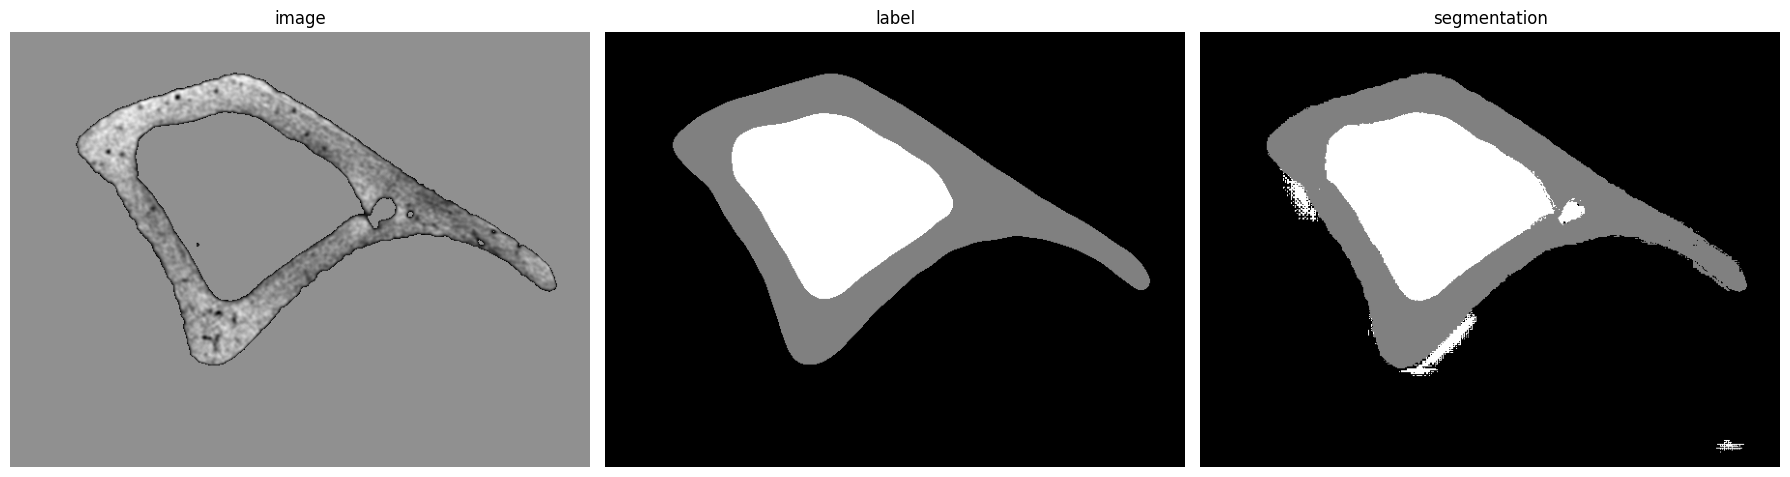

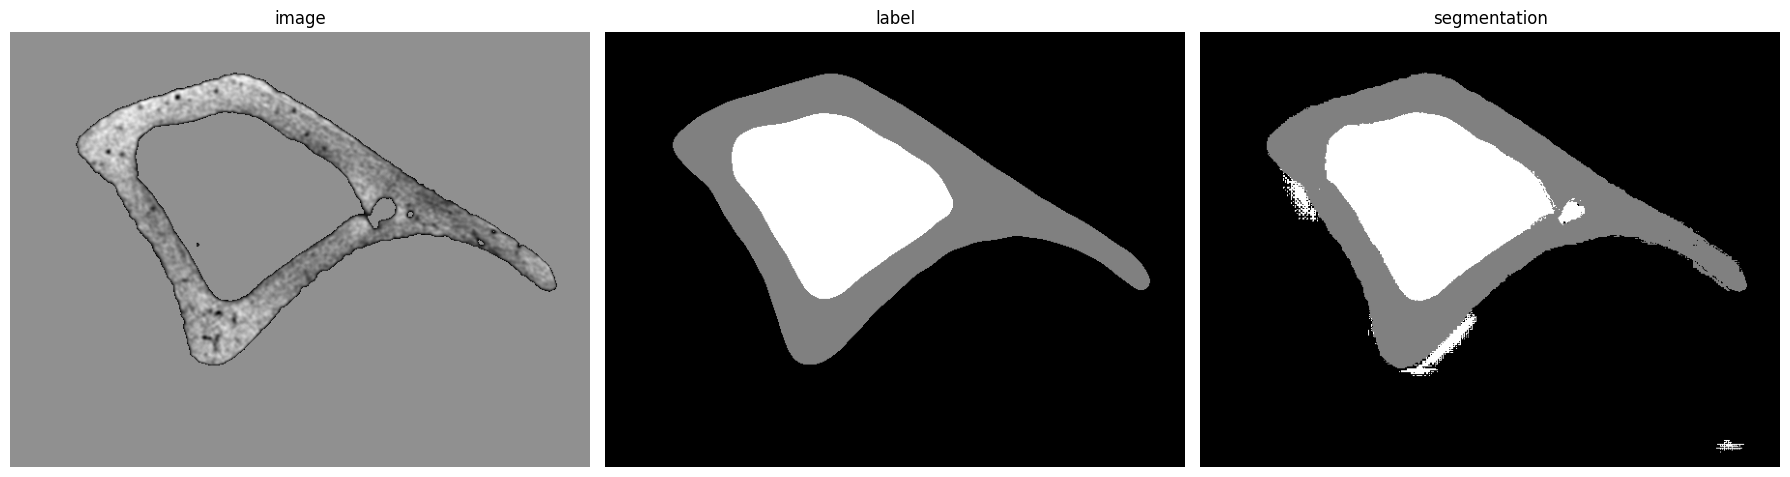

In [33]:
chosen_model = "SWINUNETR" # [UNET, ATTENTIONUNET, UNETR, SWINUNETR, DBAHNET]
predict_test_inference(chosen_model = chosen_model, slice_num = 30)

Element 1
Element 1
torch.Size([1, 1, 1080, 1080, 32])
(3, 1080, 1080, 32)
torch.Size([1, 1, 1080, 1080, 32])
(3, 1080, 1080, 32)
Inference time : (s) 30.910381317138672
Inference time : (s) 30.910381317138672


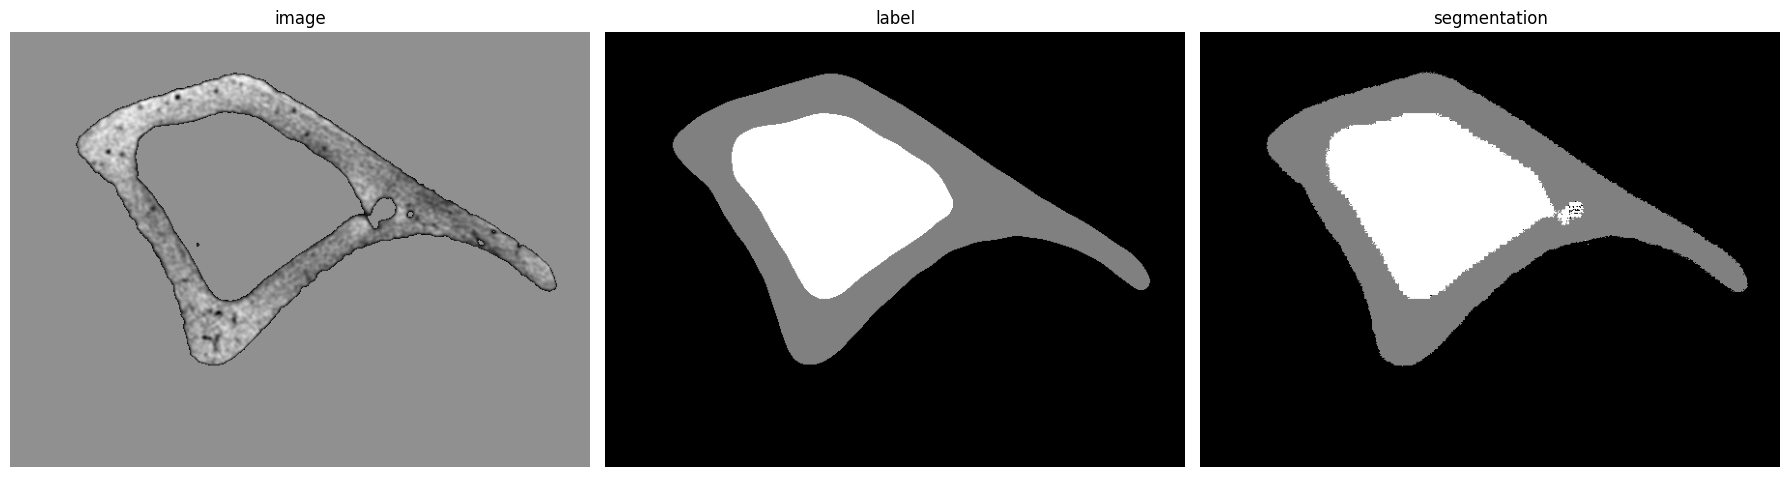

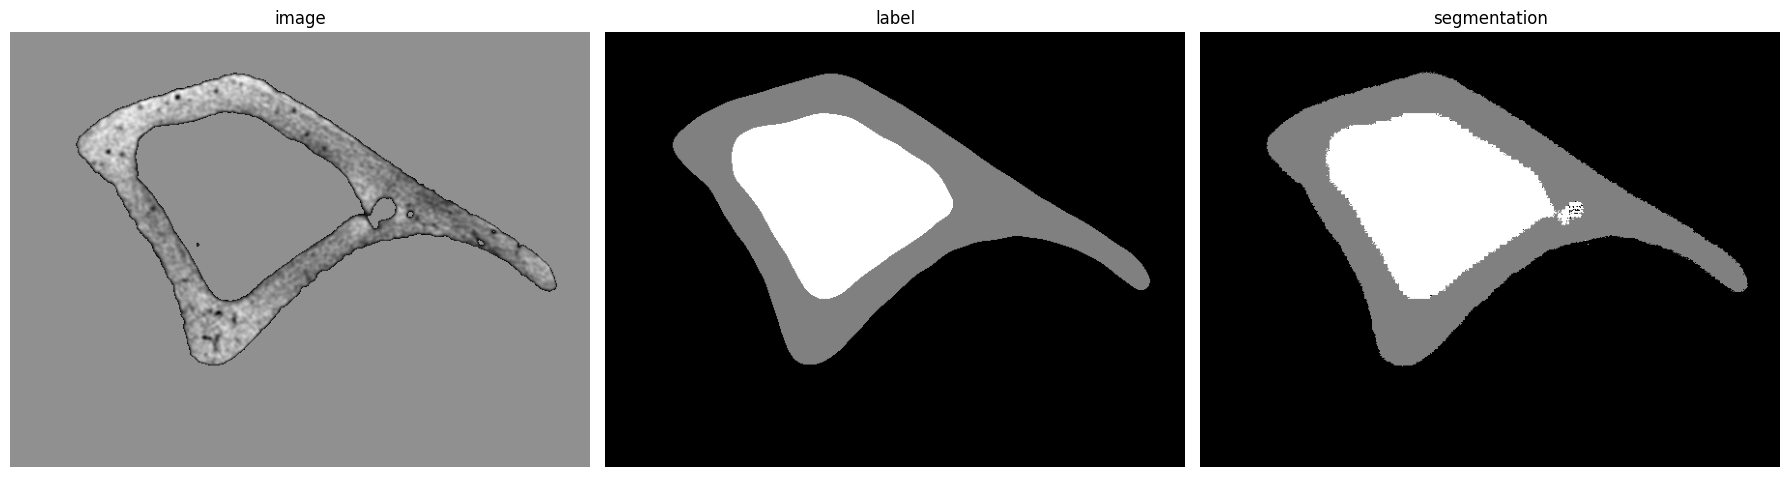

In [34]:
chosen_model = "DBAHNET" # [UNET, ATTENTIONUNET, UNETR, SWINUNETR, DBAHNET]
predict_test_inference(chosen_model = chosen_model, slice_num = 30)

# Inference by region 50%

In [64]:
import pytorch_lightning as pl
import json
from monai.utils import set_determinism
import os
from monai.data import DataLoader, Dataset
import torch
from monai.inferers import sliding_window_inference
from functools import partial
import numpy as np
import time
import matplotlib.pyplot as plt
from monai.transforms import Compose, EnsureType, AsDiscrete, Activations, LoadImaged, NormalizeIntensityd, ToTensord, AddChanneld
from bone_data.bone_data import ConvertToMultiChannelForBoneClassesd
#os.environ["CUDA_VISIBLE_DEVICES"] = "7"

set_determinism(seed=0)
with open('bone_data/data_test_50_split.json') as f:
     data = json.load(f)
test_files = data['test']
test_files_last = []
for f in test_files:
    if "B42L_0.nii.gz" in str(f):
        test_files_last.append(f)
        
test_files = test_files_last
print(test_files)
def get_test_dataloader(test_files = test_files):
    test_transform = Compose(
    [
    LoadImaged(keys=["image", "label"]),
    ConvertToMultiChannelForBoneClassesd(keys = ['label']),
    AddChanneld(keys = ["image"]),
    NormalizeIntensityd(keys = "image",
                       nonzero = True,
                       channel_wise = True),
    ToTensord(keys=["image", "label"]),
    ])
    test_ds = Dataset(data=test_files, transform=test_transform)
    test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, pin_memory = True, num_workers = 4)

    return test_loader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

[{'image': ['bone_data/images_nifti_test_50/bone_B42L_0.nii.gz'], 'label': 'bone_data/masks_nifti_test_50/mask_B42L_0.nii.gz'}]
cuda
[{'image': ['bone_data/images_nifti_test_50/bone_B42L_0.nii.gz'], 'label': 'bone_data/masks_nifti_test_50/mask_B42L_0.nii.gz'}]
cuda


In [68]:
def predict_test_inference(chosen_model = "DBAHNET", threshold  = 0.6, slice_num = 5):
    if chosen_model == "UNET":
        from trainer_bone_unet import BONEUNET
        CKPT = "ckpt/EXP_BONE_UNET_FINAL/last.ckpt"
        model = BONEUNET().load_from_checkpoint(CKPT).to(device).eval()
    if chosen_model == "ATTENTIONUNET":
        CKPT = "ckpt/EXP_BONE_ATTENTIONUNET_2/Epoch 85-MeanDiceScore0.9611.ckpt"
        from trainer_bone_attentionunet import BONEATTENTIONUNET
        model = BONEATTENTIONUNET().load_from_checkpoint(CKPT).to(device).eval()
    if chosen_model == "UNETR":
        CKPT = "ckpt/EXP_BONE_UNETR_2/Epoch 60-MeanDiceScore0.9667.ckpt"
        from trainer_bone_unetr import BONEUNETR
        model = BONEUNETR().load_from_checkpoint(CKPT).to(device).eval()
    if chosen_model == "SWINUNETR":
        from trainer_bone_swinunetr import BONESWINUNETR
        CKPT = "ckpt/EXP_BONE_SWINUNETR_2/Epoch 60-MeanDiceScore0.9739.ckpt"
        model = BONESWINUNETR().load_from_checkpoint(CKPT).to(device).eval()
    if chosen_model =="DBAHNET":
        from trainer_bone_dbahnet import  DBAHNET
        CKPT = "ckpt/EXP_BONE_DBAHNET_3_48_444_v3/Epoch 58-MeanDiceScore0.9855.ckpt"
        model = DBAHNET().load_from_checkpoint(CKPT).to(device).eval() 
    test_dataloader = get_test_dataloader()   
    roi_size = (320,320,32)
    sw_batch_size = 1
    inferer = partial(sliding_window_inference, roi_size = roi_size, sw_batch_size = sw_batch_size, predictor = model, overlap = 0.6)
    post_trans = Compose(
            [EnsureType(), Activations(sigmoid=True), AsDiscrete(threshold = threshold)]
        )

    if not os.path.exists("inference_plots"):
         os.mkdir("inference_plots")
    with torch.no_grad():
         for batch_idx, batch_data in enumerate(test_dataloader):
            print("Element 1")
            image, label = batch_data['image'].cuda(), batch_data['label'].cuda()[0].detach().cpu().numpy()
            image = image[:,:,:,:,:32]; label = label[:,:,:,:32]
            print(image.shape)
            print(np.unique(image))
            print(label.shape)
            start_time = time.time()
            seg = post_trans(inferer(image))[0].detach().cpu().numpy()
            inference_time = time.time() - start_time
            print("Inference time : (s)",inference_time)
            seg_out = np.zeros((seg.shape[1], seg.shape[2], seg.shape[3]))
            seg_out[seg[0] == 1] = 0
            seg_out[seg[1] == 1] = 1
            seg_out[seg[2] == 1] = 2
            lab_out = np.zeros((seg.shape[1], seg.shape[2], seg.shape[3]))
            lab_out[label[0] == 1] = 0
            lab_out[label[1] == 1] = 1
            lab_out[label[2] == 1] = 2        
            image = image[0][0].detach().cpu().numpy()
            plt.figure("image", (18, 6))
            plt.subplot(1, 3, 1)
            plt.axis("off")
            plt.title("image")
            plt.imshow(image[100:550,450:1050, slice_num], cmap="gray")
            plt.subplot(1, 3, 2)
            plt.axis("off")
            plt.title("label")
            plt.imshow(lab_out[100:550,450:1050, slice_num], cmap = "gray")
            plt.subplot(1, 3, 3)
            plt.axis("off")
            plt.title("segmentation")
            plt.imshow(seg_out[100:550,450:1050, slice_num], cmap ="gray")
            plt.tight_layout()
            plt.axis("off")
            plt.show()
            break
            


Element 1
Element 1
torch.Size([1, 1, 1080, 1080, 32])
torch.Size([1, 1, 1080, 1080, 32])
[-3.1476471  -3.0905237  -3.0334     -2.9762766  -2.919153   -2.8620296
 -2.8049061  -2.7477825  -2.690659   -2.6335356  -2.576412   -2.5192885
 -2.4621649  -2.4050415  -2.347918   -2.2907944  -2.233671   -2.1765473
 -2.1194239  -2.0623004  -2.0051768  -1.9480534  -1.8909298  -1.8338063
 -1.7766829  -1.7195593  -1.6624358  -1.6053122  -1.5481888  -1.4910653
 -1.4339417  -1.3768182  -1.3196948  -1.2625712  -1.2054477  -1.1483241
 -1.0912007  -1.0340772  -0.9769536  -0.91983014 -0.8627066  -0.80558306
 -0.7484596  -0.69133604 -0.63421255 -0.577089   -0.5199655  -0.46284202
 -0.4057185  -0.348595   -0.29147148 -0.23434795 -0.17722444 -0.12010093
 -0.06297742 -0.0058539   0.          0.05126961  0.10839312  0.16551663
  0.22264014  0.27976367  0.33688718  0.3940107   0.4511342   0.5082577
  0.5653812   0.6225047   0.67962825  0.73675174  0.7938753   0.8509988
  0.9081223   0.96524584  1.0223694   1.07

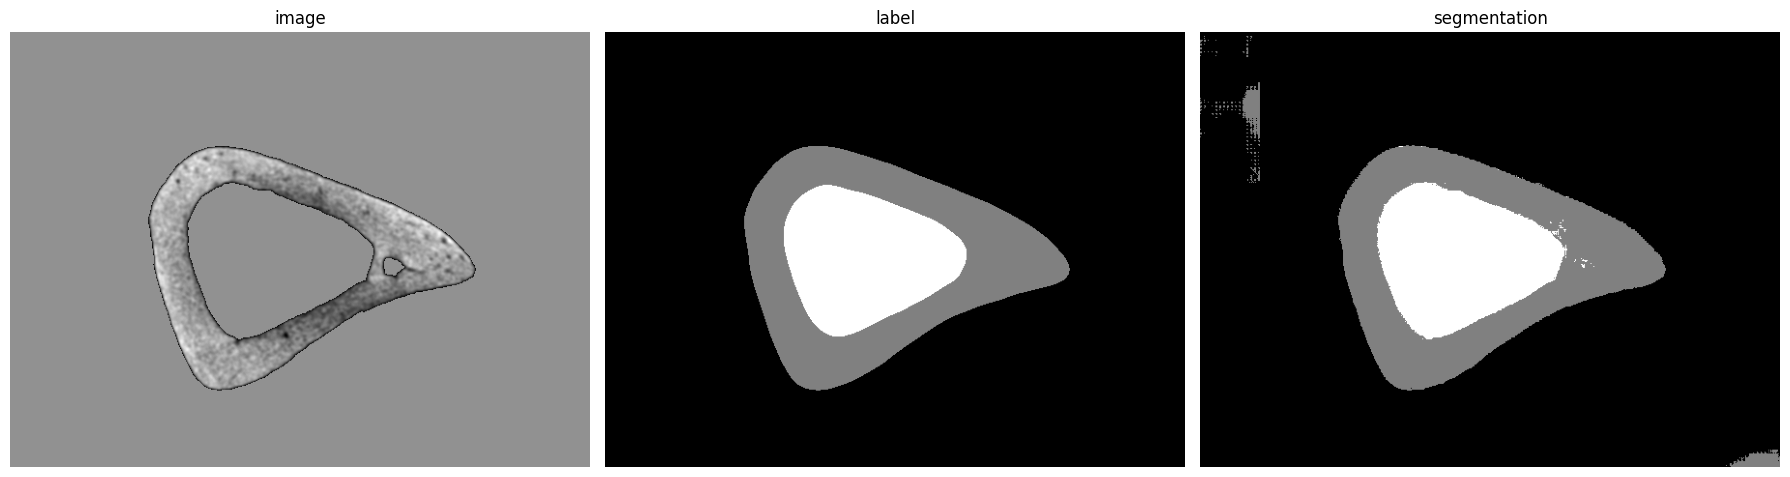

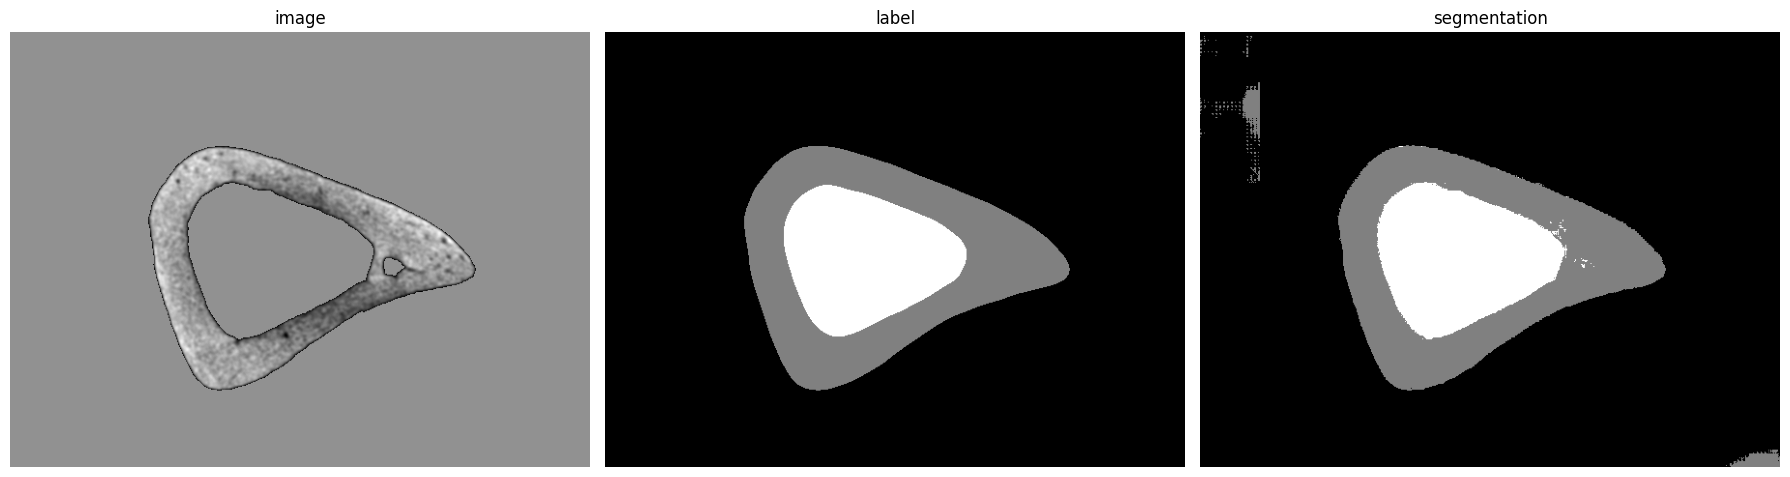

In [69]:
chosen_model = "SWINUNETR" # [UNET, ATTENTIONUNET, UNETR, SWINUNETR, DBAHNET]
predict_test_inference(chosen_model = chosen_model, slice_num = 1)

Element 1
Element 1
torch.Size([1, 1, 1080, 1080, 32])
(3, 1080, 1080, 32)
torch.Size([1, 1, 1080, 1080, 32])
(3, 1080, 1080, 32)
Inference time : (s) 30.895061492919922
Inference time : (s) 30.895061492919922


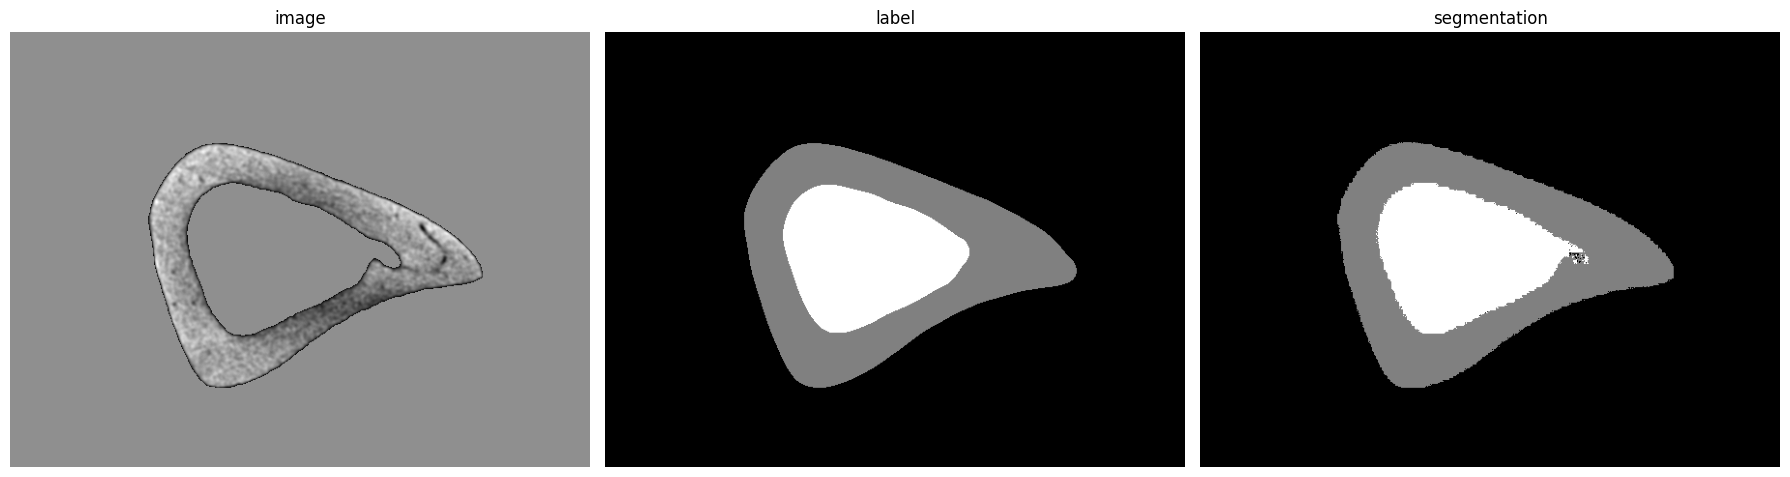

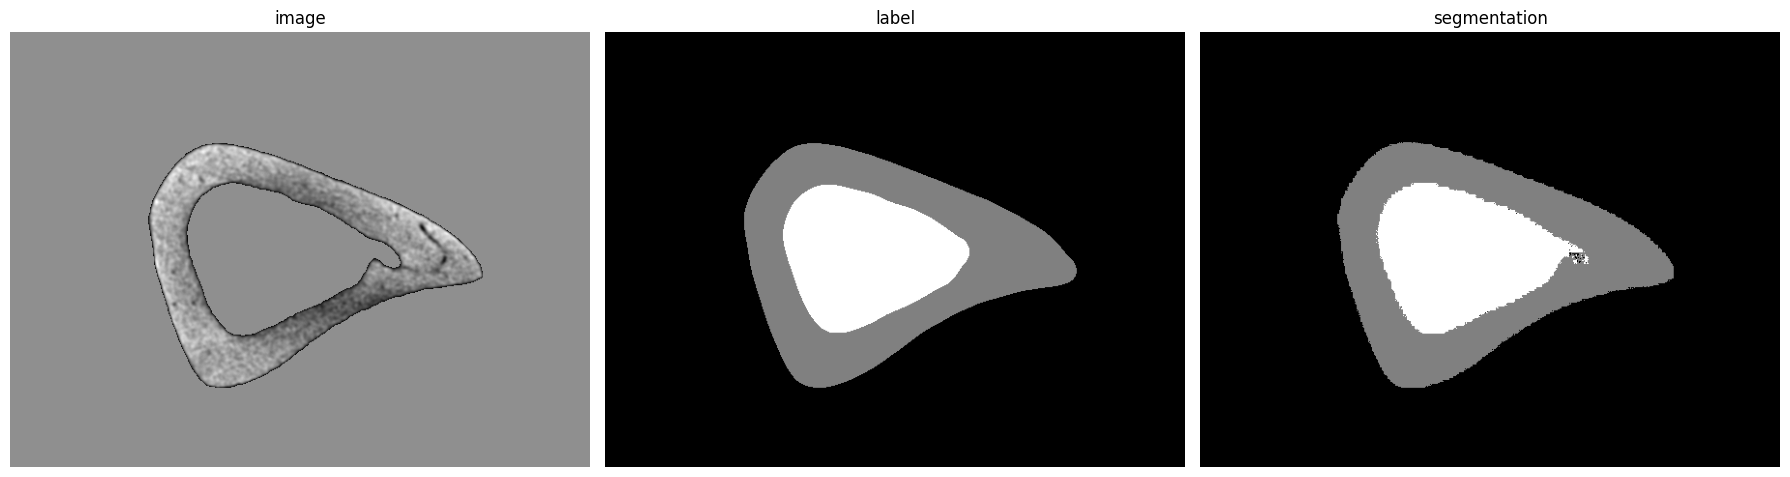

In [67]:
chosen_model = "DBAHNET" # [UNET, ATTENTIONUNET, UNETR, SWINUNETR, DBAHNET]
predict_test_inference(chosen_model = chosen_model, slice_num = 20)